# Using Python for A/B testing a website change


## Table of Contents
- [Introduction](#intro)
- [Part I - Data Cleaning](#cleaning)
- [Part II - Probability](#probability)
- [Part III - A/B Test](#ab_test)
- [Part IV - Regression](#regression)


<a id='intro'></a>
### Introduction

After users are randomly given an old and new version of the website (this may be a small difference), the goal then is to analyze whether the change had an impact on a desired result, in this case whether or not purchases or "conversions" increased compared to the old website. The goal and process is described pretty well here (https://www.optimizely.com/optimization-glossary/ab-testing/). This project was developed as I worked on the Udacity Data Science Nanodegree; the data is fake.

<a id='cleaning'></a>
## Part I - Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

`1.` **READ IN AND SUMMARIZE THE DATA**

In [2]:
ab = pd.read_csv('ab_data.csv')
ab.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


CASES

In [3]:
rows = len(ab.index)
uniqueUsers = len(ab['user_id'].unique())

print(rows, "rows with", uniqueUsers, "unique")

294478 rows with 290584 unique


CONVERSION RATE

In [4]:
(ab['converted'].sum()/rows)*100

11.965919355605511

`2.` **REVIEW MISSING VALUES**

In [5]:
nulls = ab[ab.isnull().any(axis=1)]
print(len(nulls), "rows with missing values")

0 rows with missing values


`3.` **REVIEW AND RESOLVE CONSISTENCY OF VARIABLES**

CONSISTENCY OF "NEW PAGE" AND "TREATMENT" GROUP MATCHING

In [6]:
#The "treatment" group should always have received the "new page". Is there any mismatch?
ab['mismatched'] = np.where(((ab['group'] == 'treatment') & (ab['landing_page'] == 'old_page')) | ((ab['group'] == 'control') & (ab['landing_page'] == 'new_page')),1,0)
print(ab['mismatched'].sum(), "mismatched")

3893 mismatched


NEW DATASET WITHOUT CONFLICTED ROWS

In [7]:
df2 = ab[ab.loc[:,'mismatched'] == 0].copy()

`4.` **REVIEW AND RESOLVE DUPLICATE USERS**

In [8]:
print(len(df2['user_id']), "users and", len(df2['user_id'].unique()), "are unique")

290585 users and 290584 are unique


FIND THE DUPLICATE USER ID

In [9]:
repeat_user = df2[df2['user_id'].duplicated(keep=False)]

In [10]:
repeat_user

,user_id,timestamp,group,landing_page,converted,mismatched
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,0


REMOVE ONE OF THE DUPLICATE ROWS

In [11]:
df2.drop(index=2893, inplace=True)

<a id='probability'></a>
## Part II - Probability

`1.` **PROBABILITY OF CONVERSION REGARDLESS OF PAGE**

In [12]:
df2.loc[:,'converted'].sum() / len(df2.index)

0.11959708724499628

The probability of an individual converting regardless of the page they receive is approximately 12.0%

`2.` **PROBABILITY OF RECEIVING THE NEW PAGE**

In [13]:
#create dummy variable for having received the new page
df2['new_paged'] = np.where(df2['landing_page'] == 'new_page', 1, 0)

#calculate probability of any individual receiving the new page
df2.loc[:,'new_paged'].sum() / len(df2.index)

0.50006194422266881

The probability that an individual received the new page is 50.0%

`3.` **PROBABILITY OF CONVERSION GIVEN PERSON IS IN CONTROL GROUP**

Bayes' Theorem: P(A|B) = P(B|A)P(A) / P(B)

P(B|A) = P(A and B) / P(A)

In [14]:
# P(A) = probability of having converted
pA = df2.loc[:,'converted'].sum() / len(df2.index)
pA

0.11959708724499628

In [15]:
# P(B) = probability of being in the control group = proportion of users who are in control group
controlled = df2[df2.loc[:,'group'] == 'control']
pB = len(controlled.index) / len(df2.index)
pB

0.4999380557773312

In [16]:
# P(B|A) = probability of being in control group given converted
df_converted = df2[df2.loc[:,'converted'] == 1].copy()
df_converted['controlled'] = np.where(df_converted['group'] == 'control', 1, 0)
pBA = df_converted['controlled'].sum() / len(df_converted.index)
pBA

0.50323713060742958

In [17]:
# P(A|B) = probability of converted given in control group
pAB = (pBA * pA) / pB
p_conv_in_control = pAB
p_conv_in_control

0.12038630450046119

Also works in this case:

In [18]:
#filter dataset to control group only
control = df2[df2.loc[:,'group'] == 'control']

#calculate probability of conversion for control group
control.loc[:,'converted'].sum() / len(control.index)

0.1203863045004612

Given that an individual was in the `control` group, the probability they converted is 12.0%

`4.` **PROBABILITY OF CONVERSION GIVEN PERSON IS IN TREATMENT GROUP**

In [19]:
# P(A) = probability of having converted
pA = df2.loc[:,'converted'].sum() / len(df2.index)
pA

0.11959708724499628

In [20]:
# P(B) = probability of being in the treatment group = proportion of users who are in treatment group
treated = df2[df2.loc[:,'group'] == 'treatment']
pB = len(treated.index) / len(df2.index)
pB

0.5000619442226688

In [21]:
# P(B|A) = probability of being in treatment group given converted
df_converted = df2[df2.loc[:,'converted'] == 1].copy()
df_converted['treated'] = np.where(df_converted['group'] == 'treatment', 1, 0)
pBA = df_converted['treated'].sum() / len(df_converted.index)
pBA

0.49676286939257042

In [22]:
# P(A|B) = probability of converted given in treatment group
pAB = (pBA * pA) / pB
p_conv_in_treat = pAB
p_conv_in_treat

0.11880806551510563

Also works in this case:

In [23]:
#filter dataset to treatment group only
treatment = df2[df2.loc[:,'group'] == 'treatment']

#calculate probability of conversion for treatment group
treatment.loc[:,'converted'].sum() / len(treatment.index)

0.11880806551510564

Given that an individual was in the `treatment` group, the probability they converted is 11.9%

`5.` **CONCLUSION**

Given that the probability of having converted is almost the same for people in the treatment and control groups, if not slightly higher for people in the control group, there is not sufficient evidence at this point to say that the new page leads to more conversions.

<a id='ab_test'></a>
## Part III - A/B Test

`1.` **ALTERNATIVE AND NULL HYPOTHESES**

The alternative hypothesis is that the converted rate for the new page is higher than the converted rate of the old page.
The null hypothesis is that the converted rate for the new page is less than or equal to the converted rate of the old page.

`2.` **UNDER THE NULL, ASSUMING SAME CONVERSION RATE FOR TREATMENT AND CONTROL**

In [24]:
# Get converted rate for ab_data as a whole, assumed to be the rate for both types of pages under the null
df2_crate = len(df2.query("converted == 1")) / len(df2.index)
df2_crate

0.11959708724499628

`3.` **EXAMPLE RESAMPLE WITH THE SAME SIZE AS THE ORIGINAL**

$n_{new}$

In [25]:
treat_df = df2.query("group == 'treatment'")
n_new = len(treat_df.user_id.unique())
n_new

145310

$n_{old}$

In [26]:
control_df = df2.query("group == 'control'")
n_old = len(control_df.user_id.unique())
n_old

145274

NEW TREATMENT GROUP SAMPLE

In [27]:
# sampling n_new cases from the full dataset that has p_new of 0.1196 under the null
new_page_converted = df2['converted'].sample(n_new, replace=True)

In [28]:
# see the probability of conversion in the new sample
p_new = new_page_converted.sum() / len(new_page_converted.index)
p_new

0.11919344848943637

NEW CONTROL GROUP SAMPLE

In [29]:
# sample n_new cases from the full dataset that has p_new of 0.1196 under the null
old_page_converted = df2['converted'].sample(n_old, replace=True)

In [30]:
# see what is probability of conversion in new sample
p_old = old_page_converted.sum() / len(old_page_converted.index)
p_old

0.11925051970758704

DIFFERENCE IN CONVERSION RATE

In [31]:
p_new - p_old

-5.7071218150669956e-05

`4.` **10,000 RESAMPLE ITERATIONS CALCULATING ESTIMATES UNDER THE NULL**

SIMULATING THE 10,000 NEW DIFFERENCES BETWEEN CONTROL AND TREATMENT

In [32]:
p_diffs = [] #array with the 10,000 values

for _ in range(10000):
    bootstrap_sample = df2.sample(df2.shape[0], replace = True)
    control_df = bootstrap_sample.query("group == 'control'")
    treat_df = bootstrap_sample.query("group == 'treatment'")
    control_crate = control_df.query("converted == 1").shape[0] / control_df.shape[0]
    treat_crate = treat_df.query("converted == 1").shape[0] / treat_df.shape[0]
    p_diffs.append(treat_crate - control_crate)

STANDARD DEVIATION

In [33]:
np.std(p_diffs)

0.0012119778250112515

HISTOGRAM OF THE SAMPLED DIFFERENCES

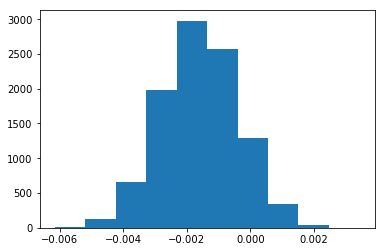

In [34]:
#Expected to look like normal distribution
plt.hist(p_diffs);

`5.` **CREATE NORMAL DISTRIBUTION FROM THE NEW SAMPLES**

In [35]:
#using the standard deviation and size of the samples above
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

`6.` **COMPARE THE ACTUAL DIFFERENCE TO THE NORMAL DISTRIBUTION OF SIMULATED DIFFERENCES UNDER THE NULL**

In [36]:
#the actual difference, again
actual_diff = p_conv_in_treat - p_conv_in_control
actual_diff

-0.0015782389853555567

PLOTTED ON THE NORMAL DISTRIBUTION

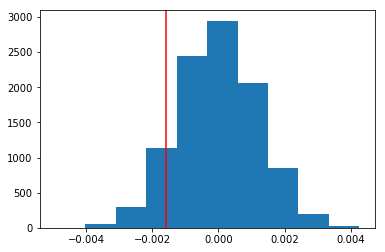

In [37]:
plt.hist(null_vals);
plt.axvline(x=actual_diff, color="red")

P-VALUE

In [38]:
#Proportion of values under the null that are greater than the actual observed difference
(null_vals > actual_diff).mean()

0.90149999999999997

`7.` **SHORTCUT ALTERNATIVE USING STATSMODELS**

In [39]:
import statsmodels.api as sm

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


THE NEEDED VARIABLES

In [40]:
convert_old = df2.query("group == 'control'").converted.sum()
convert_new = df2.query("group == 'treatment'").converted.sum()
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Z-SCORE AND P-VALUE

In [41]:
#reference: http://knowledgetack.com/python/statsmodels/proportions_ztest/
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

`8.` **CONCLUSION**

Given this P value and the z-score falling within critical values of -1.96 and 1.96, we fail to reject the null hypothesis that there is no difference in conversation rates between the new and old pages.

<a id='regression'></a>
## Part IV - Regression

Logistic regression because conversion is a categorical variable with two options (yes or no).

`1.` **PREP THE INTERCEPT AND DUMMY VARIABLES**

In [42]:
# create an intercept column and a dummy variable for treatment vs control
df2['intercept'] = 1
df2['ab_page'] = np.where(df2['group'] == 'treatment', 1, 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,mismatched,new_paged,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,0


`2.` **INSTANTIATE AND FIT THE REGRESSION MODEL USING STATSMODELS, TESTING FOR A PREDICITIVE RELATIONSHIP**

In [43]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


`3.` **SUMMARIZE**

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        19:11:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [45]:
np.exp(-0.0150)

0.98511193960306265

`4.` **CONCLUSION**

The P value is 0.190, meaning that which page a user received is not a significant predictor of conversion. The p value differs here compared to Part II because the hypothesis test is different. In this case, the null hypothesis is that there is no predictive relationship between page received and conversion, which we fail to reject.

`5.` **REGRESSION #2: THE IMPACT OF COUNTRY ON CONVERSION**

In [46]:
#merge in the countries data
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [47]:
### Create the necessary dummy variables --- need two columns for three dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.drop('US', axis=1, inplace=True)

In [48]:
# fit and summarize the logistic regression model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Jul 2018   Pseudo R-squ.:               1.521e-05
Time:                        19:11:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [49]:
np.exp(-1.9967), np.exp(-0.0408), np.log(0.0099)

(0.1357826273831706, 0.96002111497165088, -4.6152205218415929)

`6.` **CONCLUSION FOR REGRESSION #2**

It appears that country does not have an impact on conversion as the P values are not significant. 

`7.` **REGRESSION #3: THE IMPACT OF INTERACTION BETWEEN COUNTRY & PAGE ON CONVERSION**

In [50]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,mismatched,new_paged,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,1,0,1,0


In [51]:
# Dummy variables for page + country combinations
df_new['ab0_us1'] = np.where((df_new['ab_page'] == 0) & (df_new['US'] == 1), 1, 0)
df_new['ab1_us1'] = np.where((df_new['ab_page'] == 1) & (df_new['US'] == 1), 1, 0)
df_new['ab0_ca1'] = np.where((df_new['ab_page'] == 0) & (df_new['CA'] == 1), 1, 0)
df_new['ab1_ca1'] = np.where((df_new['ab_page'] == 1) & (df_new['CA'] == 1), 1, 0)
df_new['ab1_uk1'] = np.where((df_new['ab_page'] == 1) & (df_new['UK'] == 1), 1, 0)
df_new.head()

,country,timestamp,group,landing_page,converted,mismatched,new_paged,intercept,ab_page,CA,UK,US,ab0_us1,ab1_us1,ab0_ca1,ab1_ca1,ab1_uk1
user_id,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,0,1,0,0,1,0,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,1,0,0,1,0,1,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,1,0,1,0,0,0,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,0,1,0,0,1,0,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,1,0,1,0,0,0,0,0,1


In [52]:
# Fitting a LINEAR model
lm = sm.OLS(df_new['converted'], df_new[['intercept','ab0_us1','ab1_us1','ab0_ca1','ab1_ca1','ab1_uk1']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Thu, 19 Jul 2018   Prob (F-statistic):              0.197
Time:                        19:11:34   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1200      0.002     70.530      0.000       0.117       0.123
ab0_us1        0.0006      0.002      0.307      0.759      -0.003       0.004
ab1_us1       -0.0016      0.002     -0.785      0.432      -0.005       0.002
ab0_ca1       -0.0012      0.004     -0.296      0.767      -0.009       0.007
ab1_ca1       -0.0081      0.004     -1.951      0.051      -0.016    3.68e-05
ab1_uk1        0.0011      0.002      0.477      0.634      -0.004       0.006
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         9.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`8.` **CONCLUSION FOR REGRESSION #3**

Based on the p value results, the interaction between page and country does not seem to produce significant effects on conversion.